# What Every Computer Scientist Should Know About Floating-Point Arithmetic

This notebook is an edited reprint of the paper *What Every Computer Scientist Should Know About Floating-Point Arithmetic*, by David Goldberg, ACM Computing Surveys, March 1991, https://doi.org/10.1145/103162.103163

## Abstract

Floating-point arithmetic is ubiquitous in computer systems. Almost every language has a floating-point datatype; computers from PCs to supercomputers have floating-point accelerators; most compilers will be called upon to compile floating-point algorithms from time to time; and virtually every operating system must respond to floating-point exceptions such as overflow. This paper presents a tutorial on those aspects of floating-point that have a direct impact on designers of computer systems. It begins with background on floating-point representation and rounding error, and concludes with a discussion of the IEEE floating-point standard.

## Introduction

Computational Scientists often need information about floating-point arithmetic. This is a tutorial on those aspects of floating-point arithmetic (*floating-point* hereafter) that have a direct connection to computational software development. 

First we will consider *rounding error* and discuss the implications of using different rounding strategies for the basic operations of addition, subtraction, multiplication and division. We will also consider two methods of measuring rounding error, `ulps` and `relative error`. 

Secondly, we will discuss the IEEE-754 floating-point standard and the rounding method for basic operations.

## Rounding Error

Squeezing infinitely many real numbers into a finite number of bits requires an approximate representation. Although there are infinitely many integers, in most programs the result of integer computations can be stored in 32 bits (`int`). In contrast, given any fixed number of bits, most calculations with real numbers will produce quantities that cannot be exactly represented using a finite number of bits. Therefore the result of a floating-point calculation must often be rounded in order to fit back into its finite representation.

This rounding error is the characteristic feature of floating-point computation. It needs to be understood by computational scientists as under certain conditions these errors can be detrimental to the computed solution.

The IEEE-754 floating-point was introduced to standardize algorithms for addition, subtraction, multiplication, division and square root, and requires that implementations produce the same result as that algorithm. Thus, when software is executed on different computers supporting IEEE-754, the results of the basic operations will be identical. This greatly simplifies the development and porting of software across different computing platforms.

## Floating-point Formats

Floating-point representations have a base $\beta$ and a precision $p$. 

In general, a floating-point number will be represented as $\pm d.dd... d \times \beta^e$, where 
$d.dd... d$ is called the *significand*, has $p$ digits of precision and $e$ is the exponent. More precisely $\pm d_0 . d_1 d_2 ... d_{p-1} \times \beta^e$ represents the number

$$\pm \left( \sum_{n=0}^{p-1} d_n \beta^{-n} \right) \beta^e \text{, } 0 \lt d < \beta.$$

### Example: base 10
If $\beta$ = 10 and $p = 3$, then the number 0.1 is represented as $1.00 \times 10^{-1}$.

In [12]:
d = "100"

num = sum([int(d[i])*10**(-i) for i in range(len(d))])*10**(-1)

print("Actual number stored: ", num)

Actual number stored:  0.1


### Exercise: base 2
If $\beta = 2$ and $p = 24$, then the decimal number $0.1$ cannot be represented exactly, but is approximately $1.10011001100110011001101 \times 2^{-4}$. What is the decimal value of this representation?

In [2]:
d = "110011001100110011001101"



Actual number stored:  0.10000000149011612


### Maximum and minimum floating point numbers
Two other parameters associated with floating-point representations are the largest and smallest allowable exponents, $e_{max}$ and $e_{min}$. Since there are $\beta^p$ possible significands, and $e_{max} - e_{min} + 1$ possible exponents, a floating-point number can be encoded in

$$\left\lceil{\log_2\left( e_{max} - e_{min} + 1 \right)}\right\rceil +       \left\lceil{\log_2\left(\beta^{\rho}\right)}\right\rceil + 1$$

bits, where the final $+1$ is for the sign bit.

In [4]:
import bitstring
from decimal import Decimal

def print_bitstring(number, length):
    flt = bitstring.BitArray(float=number, length=length)
    if length==32:
        for s1, s2, s3 in (("Sign", "Exponent", "Significand"),
                           ("1 Bit", "8 Bits", "23 Bits"),
                           (flt.bin[0], flt.bin[1:9], flt.bin[9:])):
            print("%-5s %-11s %-52s"%(s1, s2, s3))
    if length==64:
        for s1, s2, s3 in (("Sign", "Exponent", "Significand"),
                           ("1 Bit", "11 Bits", "52 Bits"),
                           (flt.bin[0], flt.bin[1:12], flt.bin[12:])):
            print("%-5s %-11s %-52s"%(s1, s2, s3))
    
    print("Error: %g"%(number - Decimal(flt.float)))

print_bitstring(Decimal(1)/Decimal(10), 32)
print()
print_bitstring(Decimal(1)/Decimal(10), 64)

Sign  Exponent    Significand                                         
1 Bit 8 Bits      23 Bits                                             
0     01111011    10011001100110011001101                             
Error: -1.49012e-09

Sign  Exponent    Significand                                         
1 Bit 11 Bits     52 Bits                                             
0     01111111011 1001100110011001100110011001100110011001100110011010
Error: -5.55112e-18


In [5]:
for i in range(1, 10):
    float = Decimal(i)/Decimal(10)
    flt32 = bitstring.BitArray(float=float, length=32)
    flt64 = bitstring.BitArray(float=float, length=64)
    print("%.1f"%float,
          float-Decimal(flt32.float),
          float-Decimal(flt64.float))

0.1 -1.490116119384765625E-9 -5.551115123125782702118158340E-18
0.2 -2.98023223876953125E-9 -1.110223024625156540423631668E-17
0.3 -1.1920928955078125E-8 1.110223024625156540423631668E-17
0.4 -5.9604644775390625E-9 -2.220446049250313080847263336E-17
0.5 0.0 0.0
0.6 -2.384185791015625E-8 2.220446049250313080847263336E-17
0.7 1.1920928955078125E-8 4.440892098500626161694526672E-17
0.8 -1.1920928955078125E-8 -4.440892098500626161694526672E-17
0.9 2.384185791015625E-8 -2.220446049250313080847263336E-17


In [6]:
print(0.1-flt32.float, 0.1-flt64.float)

-0.7999999761581421 -0.8


There are two reasons why a real number might not be exactly representable as a floating-point number. The most common situation is illustrated by the decimal number $0.1$. Although it has a finite decimal representation, in binary it has an infinite repeating representation. Thus when $\beta = 2$, the number $0.1$ lies strictly between two floating-point numbers and is exactly representable by neither of them. A less common situation is that a real number is out of range, that is, its absolute value is larger than $\beta \times \beta^{e_{max}}$ or smaller than $1.0 \times \beta^{e_{min}}$. Most of this lecture discusses issues due to the first reason. However, numbers that are out of range will be discussed in the sections Infinity and Denormalized Numbers.

Floating-point representations are not necessarily unique. For example, both $0.01 \times 10^1$ and $1.00 \times 10^{-1}$ represent $0.1$. If the leading digit is nonzero ($d_0 \ne 0$ in equation (1) above), then the representation is said to be *normalized*. The floating-point number $1.00 \times 10^{-1}$ is normalized, while $0.01 \times 10^1$ is not. When $\beta = 2$, $p=3$, $e_{min} = -1$ and $e_{max} = 2$ there are 16 normalized floating-point numbers, as shown below.

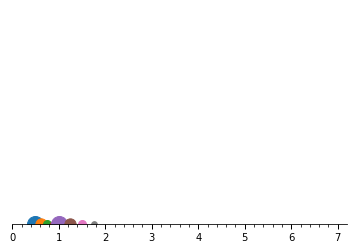

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

MAX_X = 7.2

def setup(ax):
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', width=0.75)
    ax.tick_params(which='minor', length=2.5)
    ax.set_xlim(0, MAX_X)
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0.0)
    
fig, ax = plt.subplots()
setup(ax)    
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())


def plot_number(base, significand, exponent, s):
    num = sum([int(significand[i])*base**(-i) for i in range(len(significand))])*base**(exponent)
    ax.scatter(num, 0, s=s)
    


plot_number(2, "100", -1, 256)
plot_number(2, "101", -1, 128)
plot_number(2, "110", -1, 64)
plot_number(2, "111", -1, 32)

plot_number(2, "100", 0, 256)
plot_number(2, "101", 0, 128)
plot_number(2, "110", 0, 64)
plot_number(2, "111", 0, 32)

#plot_number(2, "100", 1, 256)
#plot_number(2, "101", 1, 128)
#plot_number(2, "110", 1, 64)
#plot_number(2, "111", 1, 32)

#plot_number(2, "100", 2, 256)
#plot_number(2, "101", 2, 128)
#plot_number(2, "110", 2, 64)
#plot_number(2, "111", 2, 32)

The biggest markers correspond to numbers whose significand is 1.00. Requiring that a floating-point representation be normalized makes the representation unique. **Unfortunately, this restriction makes it impossible to represent zero!** A natural way to represent 0 is with $1.0 \times \beta^{e_{min}}$, since this preserves the fact that the numerical ordering of nonnegative real numbers corresponds to the lexicographic ordering of their floating-point representations. When the exponent is stored in a $k$ bit field, that means that only $2^k - 1$ values are available for use as exponents, since one must be reserved to represent 0.

Note that the $\times$ in a floating-point number is part of the notation, and different from a floating-point multiply operation. The meaning of the $\times$ symbol should be clear from the context. For example, the expression $(2.5 \times 10^{-3}) \times (4.0 \times 10^2)$ involves only a single floating-point multiplication.

### Exercise:
Modify the above code to have an $e_{max}$ of $3$

## Relative Error and Ulps

Since rounding error is inherent in floating-point computation, it is important to have a way to measure this error. Consider the floating-point format with $\beta = 10$ and $\rho = 3$, which will be used throughout this section.

If the result of a floating-point computation is $3.12 \times 10^{-2}$, and the answer when computed to infinite precision is .0314, it is clear that this is in error by 2 units in the last place. Similarly, if the real number .0314159 is represented as $3.14 \times 10^{-2}$, then it is in error by .159 units in the last place. In general, if the floating-point number $d.d ...d \times \beta^{e}$ is used to represent $z$, then it is in error by $|d.d ...d - (\frac{z}{\beta^e})|\beta^{p-1}$ units in the last place. 


<span style="color:red">Unless the number $z$ is larger than $\beta^{e_{\text{max}}+1}$ or smaller than $\beta^{e_{\text{min}}}$</span>

The term <em>ulps</em> will be used as shorthand for "units in the last place." If the result of a calculation is the floating-point number nearest to the correct result, it still might be in error by as much as .5 ulp. Another way to measure the difference between a floating-point number and the real number it is approximating is <em>relative error</em>, which is simply the difference between the two numbers divided by the real number. For example what is the relative error committed when approximating $3.14159$ by $3.14 \times 10^0$?




To compute the relative error that corresponds to $\frac{1}{2}$ ulp, observe that when a real number is approximated by the closest possible floating-point number $\overbrace{d.dd ... dd}^{p} \times \beta^{e}$, the error can be as large as $\overbrace{0.00 ... 00}^{p}\beta'\times \beta^{e}$, where $\beta'$ is the digit $\beta/2$, there are $p$ units in the significand of the floating-point number, and $p$ units of 0 in the significand of the error. This error is $((\beta/2)\beta^{-p}) \times \beta^{e}$. Since numbers of the form $d.dd ... dd \times \beta^e$ all have the same absolute error, but have values that range between $\beta^{e}$ and $\beta \times \beta^e$, the relative error ranges between $((\beta/2)\beta^{-p}) \times \frac{\beta^e}{\beta^e}$ and $((\beta/2)\beta^{-p}) \times \frac{\beta^e}{\beta^{e+1}}$. That is, 

\begin{equation}
\frac{1}{2}\beta^{-p} \le \frac{1}{2}\text{ulp} \le \frac{\beta}{2}\beta^{-p}
\end{equation}

In particular, the relative error corresponding to $.5$ ulp can vary by a factor of $\beta$. This factor is called the <em>wobble</em>. Setting $\epsilon = (\beta/2)\beta^{-p}$ to the largest of the bounds in the equation above, we can say that when a real number is rounded to the closest floating-point number, the relative error is always bounded by $\epsilon$, which is referred to as <em>machine epsilon</em>. 

When $3.14159$ is approximated as $3.14 \times 10^0$, what is the $\epsilon$?

Now, express the relative error in terms of $\epsilon$

To illustrate the difference between ulps and relative error, consider the real number $x = 12.35$. It is approximated by $\bar{x} = 1.24 \times 10^{1}$. The error is $0.5$ ulps, what is the relative error in terms of epsilon? 

Next consider the computation $8x$. What is the error measured in ulps and $\epsilon$? 

<span style="color:red">What is wrong with the above result?</span>

The error measured in ulps is 8 times larger, even though the relative error is the same. In general, when the base is $\beta$, a fixed relative error expressed in ulps can wobble by a factor of up to $\beta$. And conversely, as the above equation shows, a fixed error of .5 ulps results in a relative error that can wobble by $\beta$.

The most natural way to measure rounding error is in ulps. For example rounding to the nearest floating-point number corresponds to an error of less than or equal to .5 ulp. However, when analyzing the rounding error caused by various formulas, relative error is a better measure. Since $\epsilon$ can overestimate the effect of rounding to the nearest floating-point number by the wobble factor of $\beta$, error estimates of formulas will be tighter on machines with a small $\beta$.



When only the order of magnitude of rounding error is of interest, ulps and $\epsilon$ may be used interchangeably, since they differ by at most a factor of $\beta$. For example, when a floating-point number is in error by $n$ ulps, that means that the number of contaminated digits is $log_\beta n$. If the relative error in a computation is $n\epsilon$, then 

\begin{equation}
\text{contaminated digits} \approx log_\beta n
\label{eq:contaminated} \tag{1}
\end{equation}


## Guard Digits

One method of computing the difference between two floating-point numbers is to compute the difference exactly and then round it to the nearest floating-point number. This is very expensive if the operands differ greatly in size. Assuming $p = 3$, $2.15 \times 10^{12} - 1.25 \times 10^{-5}$ would be calculated as:


Rather than using all these digits, floating-point hardware normally operates on a fixed number of digits. Suppose that the number of digits kept is $p$, and that when the smaller operand is shifted right, digits are simply discarded (as opposed to rounding). Then $2.15 \times 10^{12} - 1.25 \times 10^{-5}$ becomes:


The answer is exactly the same as if the difference had been computed exactly and then rounded. Take another example: 10.1 - 9.93. 

The correct answer is .17, so the computed difference is off by 30 ulps and is wrong in every digit! How bad can the error be?

#### Theorem 1


*Using a floating-point format with parameters $\beta$ and $p$, and computing differences using $p$ digits, the relative error of the result can be as large as $\beta - 1$.*

#### Proof

A relative error of $\beta - 1$ in the expression $x - y$ occurs when $x = 1.00 ... 0$ and $y = .\rho\rho...\rho$, where $\rho = \beta - 1$. Here $y$ has  $p$ digits (all equal to $\rho$). The exact difference is $x - y = \beta^{-p}$. However, when computing the answer using only  $p$ digits, the rightmost digit of $y$ gets shifted off, and so the computed difference is $\beta^{-p+1}$. Thus the error is $\beta^{-p} - \beta^{-p+1} = \beta^{-p} (\beta - 1)$, and the relative error is $\beta^{-p}(\beta - 1)/\beta^{-p} = \beta - 1$.

When $\beta=2$, the absolute error can be as large as the result, and when $\beta=10$, it can be nine times larger. To put it another way, when $\beta=2$, equation 1 shows that the number of contaminated digits is $log_2(1/\epsilon) = log_2(2^{p}) =  p$. That is, all of the  $p$ digits in the result are wrong! Suppose that one extra digit is added to guard against this situation (a guard digit). That is, the smaller number is truncated to  $p + 1$ digits, and then the result of the subtraction is rounded to  $p$ digits. With a guard digit, the previous example becomes 

and the answer is exact. With a single guard digit, the relative error of the result may be greater than $\epsilon$, as in 110 - 8.59. 


\begin{align}
	 x &= 1.10 \times 10^{2} \\
     y &= .085 \times 10^{2} \\
     x - y &= 1.015 \times 10^{2}
\end{align}
This rounds to $102$, compared with the correct answer of $101.41$, for a relative error of $.006$, which is greater than $\epsilon = .005$. In general, the relative error of the result can be only slightly larger than $\epsilon$. More precisely, we have Theorem 2.

#### Theorem 2

*If $x$ and $y$ are floating-point numbers in a format with parameters $\beta$ and  $p$, and if subtraction is done with  $p + 1$ digits (i.e. one guard digit), then the relative rounding error in the result is less than $2\epsilon$.*


Let's repeat the last computation with a guard digit:

### Cancellation

The last section can be summarized by saying that without a guard digit, the relative error committed when subtracting two nearby quantities can be very large. In other words, the evaluation of any expression containing a subtraction (or an addition of quantities with opposite signs) could result in a relative error so large that *all* the digits are meaningless (Theorem 1). When subtracting nearby quantities, the most significant digits in the operands match and cancel each other. There are two kinds of cancellation: catastrophic and benign. 

*Catastrophic cancellation* occurs when the operands are subject to rounding errors. For example in the quadratic formula, the expression $b^2 - 4ac$ occurs. The quantities $b$ and $4ac$ are subject to rounding errors since they are the results of floating-point multiplications. Suppose that they are rounded to the nearest floating-point number, and so are accurate to within $.5$ulp. When they are subtracted, cancellation can cause many of the accurate digits to disappear, leaving behind mainly digits contaminated by rounding error. Hence the difference might have an error of many ulps. For example, consider $b = 3.34$, $a = 1.22$, and $c = 2.28$. 

The exact value of $b^{2} - 4ac$ is $.0292$. But $b^{2}$ rounds to $11.2$ and $4ac$ rounds to $11.1$, hence the final answer is $.1$ which is an error by $70$ ulps, even though $11.2 - 11.1$ is exactly equal to $.1$. The subtraction did not introduce any error, but rather exposed the error introduced in the earlier multiplications.


*Benign cancellation* occurs when subtracting exactly known quantities. If $x$ and $y$ have no rounding error, then by Theorem 2 if the subtraction is done with a guard digit, the difference $x-y$ has a very small relative error (less than $2\epsilon$).

The expression $x^{2} - y^{2}$ is another formula that exhibits catastrophic cancellation. It is more accurate to evaluate it as $(x - y)(x + y)$. This improved form still has a subtraction, but it is a benign cancellation of quantities without rounding error, not a catastrophic one. By Theorem 2, the relative error in $x - y$ is at most $2\epsilon$. The same is true of $x + y$. Multiplying two quantities with a small relative error results in a product with a small relative error (see the section on Rounding Error). 

In order to avoid confusion between exact and computed values, the following notation is used. Whereas $x - y$ denotes the exact difference of $x$ and $y$, $x \ominus y$ denotes the computed difference (i.e., with rounding error). Similarly $\oplus$, $\otimes$, and $\oslash$ denote computed addition, multiplication, and division, respectively. All caps indicate the computed value of a function, as in $LN(x)$ or $SQRT(x)$. Lowercase functions and traditional mathematical notation denote their exact values as in $ln(x)$ and $\sqrt(x)$.


Although $(x \ominus y) \otimes (x \oplus y)$ is an excellent approximation to $x^{2} - y^{2}$, the floating-point numbers $x$ and $y$ might themselves be approximations to some true quantities $\hat{x}$ and $\hat{y}$. For example, $\hat{x}$ and $\hat{y}$ might be exactly known decimal numbers that cannot be expressed exactly in binary. In this case, even though $x \ominus y$ is a good approximation to $x - y$, it can have a huge relative error compared to the true expression $\hat{x} - \hat{y}$
, and so the advantage of $(x + y)(x - y)$ over $x^{2} - y^{2}$ is not as dramatic. Since computing $(x + y)(x - y)$ is about the same amount of work as computing $x^{2} - y^{2}$, it is clearly the preferred form in this case. In general, however, replacing a catastrophic cancellation by a benign one is not worthwhile if the expense is large, because the input is often (but not always) an approximation. But eliminating a cancellation entirely 
is worthwhile even if the data are not exact. Throughout this lecture, it will be assumed that the floating-point inputs to an algorithm are exact and that the results are computed as accurately as possible.

The expression $x^{2} - y^{2}$ is more accurate when rewritten as $(x - y)(x + y)$ because a catastrophic cancellation is replaced with a benign one. We next present more interesting examples of formulas exhibiting catastrophic cancellation that can be rewritten to exhibit only benign cancellation.

The area of a triangle can be expressed directly in terms of the lengths of its sides $a$, $b$, and $c$ as
\begin{equation}
A = \sqrt{s(s-a)(s-b)(s-c)}, \\
\text{where}    s=\frac{a+b+c}{2}
\label{eq:triangle}\tag{4}
\end{equation}

Suppose the triangle is very flat; that is, $a \approx b + c$. Then $s \approx a$, and the term $(s - a)$ in equation $\eqref{eq:triangle}$ subtracts two nearby numbers, one of which may have rounding error. For example, if $a = 9.0$, $b = c = 4.53$, the correct value of $s$ is $9.03$ and $A$ is $2.342$. 

There is a way to rewrite formula (4) so that it will return accurate results even for flat triangles [Kahan 1986]. It is 

\begin{equation}
A = [(1a + (b+c))(c-(a-b)) \times (c+ (a-b))(a+(b-c))]^{\frac{1}{2}}/4, \\
a \ge b \ge c
\label{eq:triangle_modified}\tag{5}
\end{equation}

If $a$, $b$, and $c$ do not satisfy $a \ge b \ge c$, rename them before applying $\eqref{eq:triangle_modified}$. It is straightforward to check that the right-hand sides of (4) and $\eqref{eq:triangle_modified}$ are algebraically identical. Using the values of $a$, $b$, and $c$ above gives a computed area of $2.35$, which is 1 ulp in error and much more accurate than the first formula. Repeat the last example using formula (5). 

#### Theorem 3
*The rounding error incurred when using Equation 5 to compute the area of a triangle is at most $11\epsilon$, provided that subtraction is performed with a guard digit, $\epsilon \le .005$, and that square roots are computed to within 1/2 ulp.*

The condition that $\epsilon < .005$ is met in virtually every actual floating-point system. For example when $\beta = 2$, $p \ge 8$ ensures that $\epsilon < .005$, and when $\beta = 10$, $p \ge 3$ is enough. 

In statements like Theorem 3 that discuss the relative error of an expression, it is understood that the expression is computed using floating-point arithmetic. 

Error bounds are usually too pessimistic. In the numerical example given above, the computed value of $\eqref{eq:triangle_modified}$ is 2.35, compared with a true value of 2.34216 for a relative error of $0.7\epsilon$, which is much less than $11\epsilon$. The main reason for computing error bounds is not to get precise bounds but rather to verify that the formula does not contain numerical problems. 

A final example of an expression that can be rewritten to use benign cancellation is $(1 + x)^{n}$, where $x \lt\lt 1$. This expression arises in financial calculations. Consider depositing \\$100 every day into a bank account that earns an annual interest rate of 6\%, compounded daily. If $n = 365$ and $i = .06$, the amount of money accumulated at the end of one year is $100[(1+i/n)^n-1]/(i/n)$ dollars. 

In [157]:
getcontext().prec = 9

n = Decimal(365)
i = Decimal('0.06')

result = 100*((1+(i/n))**n - 1)/(i/n)

print(result)

37613.2073


The reason for the problem is easy to see. The expression $1 + i/n$ involves adding 1 to .0001643836, so the low order bits of $i/n$ are lost. This rounding error is amplified when $1 + i/n$ is raised to the $n$th power. 

The troublesome expression $(1 + i/n)^{n}$ can be rewritten as $exp[nln(1 + i/n)]$, where now the problem is to compute $ln(1 + x)$ for small $x$. One approach is to use the approximation $ln(1 + x) \approx x$, in which case the payment becomes \\$37617.26, which is off by \\$3.21 and even less accurate than the obvious formula. But there is a way to compute $ln(1 + x)$ very accurately, as Theorem 4 shows. This formula yields \\$37614.07, accurate to within two cents! 

Theorem 4 assumes that $LN(x)$ approximates $ln(x)$ to within 1/2 ulp. The problem it solves is that when $x$ is small, $LN(1 \oplus x)$ is not close to $ln(1 + x)$ because $1 \oplus x$ has lost the information in the low order bits of $x$. That is, the computed value of $ln(1 + x)$ is not close to its actual value when $x \lt\lt 1$.

#### Theorem 4

*If $ln(1 + x)$ is computed using the formula* 
\begin{equation}
ln(1 + x) = \begin{cases}
x &  \text{for} &  1 \oplus x = 1 \\
\frac{xln(1+x)}{(1 + x) - 1} & \text{for} & 1 \oplus x \ne 1
\end{cases}
\end{equation}

*the relative error is at most $5\epsilon$ when $0 \le x < 3/4$, provided subtraction is performed with a guard digit, $\epsilon < 0.1$, and $ln$ is computed to within 1/2 ulp.*

### Exactly Rounded Operations

When floating-point operations are done with a guard digit, they are not as accurate as if they were computed exactly then rounded to the nearest floating-point number. Operations performed in this manner will be called exactly rounded.
We have seen that a single guard digit will not always give exactly rounded results. The previous section gave several examples of algorithms that require a guard digit in order to work properly. This section gives examples of algorithms that require exact rounding.

So far, the definition of rounding has not been given. Rounding is straightforward, with the exception of how to round halfway cases; for example, should 12.5 round to 12 or 13? One school of thought divides the 10 digits in half, letting ${0, 1, 2, 3, 4}$ round down, and ${5, 6, 7, 8, 9}$ round up; thus 12.5 would round to 13.
Another school of thought says that since numbers ending in 5 are halfway between two possible roundings, they should round down half the time and round up the other half. One way of obtaining this 50\% behavior to require that the rounded result have its least significant digit be even. Thus 12.5 rounds to 12 rather than 13 because 2 is even. Which of these methods is best, round up or round to even? Reiser and Knuth [1975] offer the following reason for preferring round to even.

#### Theorem 5

Let x and y be floating-point numbers, and define $x_{0} = x$, $x_{1} = (x_{0} \ominus y) \oplus y, ..., x_{n} = (x_{n-1} \ominus y) \oplus y$. If $\oplus$ and $\ominus$ 
are exactly rounded using round to even, then either $x_{n} = x$ for all n or $x_{n} = x_{1}$ for all $n \ge 1$.



Repeat the above with Round to even.

## The IEEE Standard

IEEE 754 is a binary standard that requires $\beta = 2$, $p = 24$ for single precision and $p = 53$ for double precision [IEEE 1987]. It also specifies the precise layout of bits in a single and double precision. 


  This section provides a tour of the IEEE standard. Each subsection discusses one aspect of the standard and why it was included. It is not the purpose of this paper to argue that the IEEE standard is the best possible floating-point standard but rather to accept the standard as given and provide an introduction to its use. For full details consult the standards themselves.



### Formats and Operations


#### Base


  There are several reasons why the base for floating point operations is commonly 2. The section on Relative Error and Ulps mentioned one reason: the results of error analyses are much tighter when $\beta is 2$ because a rounding error of .5 ulp wobbles by a factor of $\beta$ when computed as a relative error, and error analyses are almost always simpler when based on relative error. A related reason has to do with the effective precision for large bases. Consider $\beta = 16$, $p = 1$ compared to $\beta = 2$, $p = 4$. Both systems have 4 bits of significand. Consider the computation of 15/8. When $\beta = 2$, 15 is represented as $1.111 \times 2^{3}$, and 15/8 as $1.111 \times 2^{0}$. So 15/8 is exact. However, when $\beta = 16$, 15 is represented as $F \times 16^{0}$, where $F$ is the hexadecimal digit for 15. But $15/8$ is represented as $1 \times 16^{0}$, which has only one bit correct. In general, base 16 can lose up to 3 bits, so that a precision of $p$ hexadecimal digits can have an effective precision as low as $4p - 3$ rather than $4p$ binary bits. 



Another advantage of using \beta = 2 is that there is a way to gain an extra bit of significance. Since floating-point numbers are always normalized, the most significant bit of the significand is always 1, and there is no reason to waste a bit of storage representing it. Formats that use this trick are said to have a hidden bit. It was already pointed out in <a href="ncg_goldberg.html#682">Floating-point Formats</a> that this requires a special convention for 0. The method given there was that an exponent of e_{min} - 1 and a significand of all zeros represents 0. 




  IEEE 754 single precision is encoded in 32 bits using 1 bit for the sign, 8 bits for the exponent, and 23 bits for the significand. However, it uses a hidden bit, so the significand is 24 bits (p = 24), even though it is encoded using only 23 bits.

#### Precision

<p>
  <a name="811"> </a><font face="Verdana, Arial, Helvetica, sans-serif">The IEEE standard defines four different precisions: single, double, single-extended, and double-extended. In IEEE 754, single and double precision correspond roughly to what most floating-point hardware provides. Single precision occupies a single 32 bit word, double precision two consecutive 32 bit words. Extended precision is a format that offers at least a little extra precision and exponent range (<a href="ncg_goldberg.html#812">TABLE&nbsp;D-1</a>).<p>
<table border="1" bordercolorlight="#FFFFFF" bordercolordark="#000000"
       cellpadding="5" cellspacing="0">
  <caption ALIGN="left"><b><font face="Verdana, Arial, Helvetica, sans-serif" size="-1"><a name="812"> </a><font face="Verdana, Arial, Helvetica, sans-serif" size="-1"><b>TABLE D-1 	</b>&nbsp;&nbsp;IEEE 754 Format Parameters</font></font></b></caption>
  <tr bgcolor="#CCCCCC"><div align="center">
    <th colspan=1 rowspan=2><font face="Verdana, Arial, Helvetica, sans-serif" color="#003366"><a name="817"> </a>Parameter</font></th>
    <th colspan=4 rowspan=1><font face="Verdana, Arial, Helvetica, sans-serif" color="#003366"><a name="818"> </a>Format</font></th>
  </div></tr>
  <tr bgcolor="#CCCCCC"><div align="center">
    <th><font face="Verdana, Arial, Helvetica, sans-serif" color="#003366"><a name="823"> </a>Single</font></th>
    <th><font face="Verdana, Arial, Helvetica, sans-serif" color="#003366"><a name="824"> </a>Single-Extended</font></th>
    <th><font face="Verdana, Arial, Helvetica, sans-serif" color="#003366"><a name="825"> </a>Double</font></th>
    <th><font face="Verdana, Arial, Helvetica, sans-serif" color="#003366"><a name="826"> </a>Double-Extended</font></th>
  </div></tr>
  <tr>
    <td>
<a name="827"> </a><font face="Arial,Helvetica"><em>p
</em></font></td>
    <td>
<a name="828"> </a> $24$
</td>
    <td>
<a name="829"> </a> $\le 32$
</td>
    <td>
<a name="830"> </a>$53$
</td>
    <td>
<a name="831"> </a> $\ge 64$
</td>
  </tr>
  <tr>
    <td>
<a name="832"> </a><font face="Arial,Helvetica"><em>e</em></font><sub>max
</sub></td>
    <td>
<a name="833"> </a>$+127$
</td>
    <td>
<a name="834"> </a> $\ge 1023$
</td>
    <td>
<a name="835"> </a> $+1023$
</td>
    <td>
<a name="836"> </a> $\ge 16383$
</td>
  </tr>
  <tr>
    <td>
<a name="837"> </a><font face="Arial,Helvetica"><em>e</em></font><sub>min</sub> 
</td>
    <td>
<a name="838"> </a>$-126$
</td>
    <td>
<a name="839"> </a> $\le -1022$
</td>
    <td>
<a name="840"> </a>$-1022$
</td>
    <td>
<a name="841"> </a> $\le -16382$
</td>
  </tr>
  <tr>
    <td>
<a name="842"> </a>Exponent width in bits
</td>
    <td>
<a name="843"> </a>$8$
</td>
    <td>
<a name="844"> </a> $\ge 11$
</td>
    <td>
<a name="845"> </a>$11$
</td>
    <td>
<a name="846"> </a> $ \ge 15$
</td>
  </tr>
  <tr>
    <td>
<a name="847"> </a>Format width in bits
</td>
    <td>
<a name="848"> </a>$32$
</td>
    <td>
<a name="849"> </a> $\ge 43$
</td>
    <td>
<a name="850"> </a>$64$
</td>
    <td>
<a name="851"> </a> $\ge 79$
</td>
  </tr>
</table>


</p>
<br></font>
</p>


<p>
  <a name="853"> </a><font face="Verdana, Arial, Helvetica, sans-serif">The IEEE standard only specifies a lower bound on how many extra bits extended precision provides.  </font>
</p>


<p>
  <a name="857"> </a><font face="Verdana, Arial, Helvetica, sans-serif">One motivation for extended precision comes from calculators, which will often display 10 digits, but use 13 digits internally. By displaying only 10 of the 13 digits, the calculator appears to the user as a "black box" that computes exponentials, cosines, etc. to 10 digits of accuracy. For the calculator to compute functions like exp, log and cos to within 10 digits with reasonable efficiency, it needs a few extra digits to work with. It is not hard to find a simple rational expression that approximates log with an error of 500 units in the last place. Thus computing with 13 digits gives an answer correct to 10 digits. By keeping these extra 3 digits hidden, the calculator presents a simple model to the operator. </font>
</p>



<h4>
  <a name="861"> </a><font color="#003366" face="Verdana, Arial, Helvetica, sans-serif">2.1.3 Exponent </font>
</h4>


<p>
  <a name="862"> </a><font face="Verdana, Arial, Helvetica, sans-serif">Since the exponent can be positive or negative, some method must be chosen to represent its sign. Two common methods of representing signed numbers are sign/magnitude and two's complement. Sign/magnitude is the system used for the sign of the significand in the IEEE formats: one bit is used to hold the sign, the rest of the bits represent the magnitude of the number. The two's complement representation is often used in integer arithmetic. In this scheme, a number in the range [-2<sup>p-1</sup>, 2<sup>p-1</sup> - 1] is represented by the smallest nonnegative number that is congruent to it modulo 2<sup>p</sup>. </font>
</p>


<p>
  <a name="863"> </a><font face="Verdana, Arial, Helvetica, sans-serif">The IEEE binary standard does not use either of these methods to represent the exponent, but instead uses a <font face="Arial,Helvetica"><em>biased</em></font> representation. In the case of single precision, where the exponent is stored in 8 bits, the bias is 127 (for double precision it is 1023). What this means is that if $ \overline{k}$ is the value of the exponent bits interpreted as an unsigned integer, then the exponent of the floating-point number is $ \overline{k} -127$. This is often called the <em>unbiased exponent</em> to distinguish from the biased exponent $ \overline{k}$. </font>
</p>


<h4>
  <a name="865"> </a><font color="#003366" face="Verdana, Arial, Helvetica, sans-serif">Operations </font>
</h4>


<p>
  <a name="866"> </a><font face="Verdana, Arial, Helvetica, sans-serif">The IEEE standard requires that the result of addition, subtraction, multiplication and division be exactly rounded. That is, the result must be computed exactly and then rounded to the nearest floating-point number (using round to even). The section <a href="ncg_goldberg.html#693">Guard Digits</a> pointed out that computing the exact difference or sum of two floating-point numbers can be very expensive when their exponents are substantially different. That section introduced guard digits, which provide a practical way of computing differences while guaranteeing that the relative error is small. However, computing with a single guard digit will not always give the same answer as computing the exact result and then rounding. By introducing a second guard digit and a third <em>sticky</em> bit, differences can be computed at only a little more cost than with a single guard digit, but the result is the same as if the difference were computed exactly and then rounded [Goldberg 1990]. Thus the standard can be implemented efficiently. </font>
</p>


<p>
  <a name="867"> </a><font face="Verdana, Arial, Helvetica, sans-serif">One reason for completely specifying the results of arithmetic operations is to improve the portability of software. When a program is moved between two machines and both support IEEE arithmetic, then if any intermediate result differs, it must be because of software bugs, not from differences in arithmetic. Another advantage of precise specification is that it makes it easier to reason about floating-point. Proofs about floating-point are hard enough, without having to deal with multiple cases arising from multiple kinds of arithmetic. Just as integer programs can be proven to be correct, so can floating-point programs, although what is proven in that case is that the rounding error of the result satisfies certain bounds. Theorem 4 is an example of such a proof. These proofs are made much easier when the operations being reasoned about are precisely specified. Once an algorithm is proven to be correct for IEEE arithmetic, it will work correctly on any machine supporting the IEEE standard. </font>
</p>

<h3>
  <a name="875"> </a><font color="#003366" face="Verdana, Arial, Helvetica, sans-serif">Special Quantities </font>
</h3>


<p>
  <a name="877"> </a><font face="Verdana, Arial, Helvetica, sans-serif">The IEEE standard has some special quantities - NaNs (<em>Not a Number</em>) and infinities. Without any special quantities, there is no good way to handle exceptional situations like taking the square root of a negative number, other than aborting computation. 
</font>
</p>


<p>
  <a name="754"> </a><font face="Verdana, Arial, Helvetica, sans-serif">The IEEE standard specifies the following special values: $\pm 0$, denormalized numbers, $\pm \inf$ and NaNs (there is more than one NaN, as explained in the next section). These special values are all encoded with exponents of either $e_{max} + 1$ or $e_{min} -1$ (it was already pointed out that 0 has an exponent of $e_{min} -1$. <p>
    
<table border="1" bordercolorlight="#FFFFFF" bordercolordark="#000000"
       cellpadding="5" cellspacing="0">
  <caption ALIGN="left"><b><font face="Verdana, Arial, Helvetica, sans-serif" size="-1"><a name="878"> </a><font face="Verdana, Arial, Helvetica, sans-serif" size="-1"><b>TABLE D-2 	</b>&nbsp;&nbsp;IEEE 754 Special Values</font></font></b></caption>
  <tr bgcolor="#CCCCCC"><div align="center">
    <th><font face="Verdana, Arial, Helvetica, sans-serif" color="#003366"><a name="881"> </a>Exponent</font></th>
    <th><font face="Verdana, Arial, Helvetica, sans-serif" color="#003366"><a name="882"> </a>Fraction</font></th>
    <th><font face="Verdana, Arial, Helvetica, sans-serif" color="#003366"><a name="883"> </a>Represents</font></th>
  </div></tr>
  <tr>
    <td>
<a name="884"> </a> $e = e_{min} -1$
</td>
    <td>
<a name="885"> </a>$f = 0$
</td>
    <td>
<a name="886"> </a>$ \pm 0$
</td>
  </tr>
  <tr>
    <td>
<a name="887"> </a>$e = e_{min} -1$
</td>
    <td>
<a name="888"> </a>$f \neq 0 $ </td>
    <td>
<a name="889"> </a> $0.f \times 2^{e_{min}} $ </td>
  </tr>
  <tr>
    <td>
<a name="890"> </a> $e_{min} \le e \le e_{max}$</td>
    <td>
<a name="891"> </a> $--$
</td>
    <td>
<a name="892"> </a> $1f \times 2^{e} $</td>
  </tr>
  <tr>
    <td>
<a name="893"> </a>$e = e_{max} +1$
</td>
    <td>
<a name="894"> </a>$f = 0$
</td>
    <td>
<a name="895"> </a> $\pm \inf $</td>
  </tr>
  <tr>
    <td>
<a name="896"> </a> $e = e_{max} +1$
</td>
    <td>
<a name="897"> $ f \neq 0$
</td>
    <td>
<a name="898"> </a><code> </code>NaN
</td>
  </tr>
</table>


</p>
<br></font>
</p>


<h3>
  <a name="899"> </a><font color="#003366" face="Verdana, Arial, Helvetica, sans-serif">NaNs </font>
</h3>


<p>
  <a name="4986"> </a><font face="Verdana, Arial, Helvetica, sans-serif">Traditionally, the computation of 0/0 
 has been treated as an unrecoverable error which causes a computation to halt. However, there are examples where it makes sense for a computation to continue in such a situation. Consider a subroutine that finds the zeros of a function <font face="Arial,Helvetica"><em>f</em></font>, say <code>zero(f)</code>. Traditionally, zero finders require the user to input an interval [<font face="Arial,Helvetica"><em>a</em></font>, <font face="Arial,Helvetica"><em>b</em></font>] on which the function is defined and over which the zero finder will search. That is, the subroutine is called as <code>zero(f</code>, <code>a</code>, <code>b)</code>. A more useful zero finder would not require the user to input this extra information. This more general zero finder is especially appropriate for calculators, where it is natural to simply key in a function, and awkward to then have to specify the domain. However, it is easy to see why most zero finders require a domain. The zero finder does its work by probing the function <code>f</code> at various values. If it probed for a value outside the domain of <code>f</code>, the code for <code>f</code> might well compute 0/0, and the computation would halt, unnecessarily aborting the zero finding process. </font>
</p>


<p>
  <a name="4991"> </a><font face="Verdana, Arial, Helvetica, sans-serif">This problem can be avoided by introducing a special value called NaN, and specifying that the computation of expressions like 0/0
 produce NaN, rather than halting. It is easy to see what the result of combining a NaN with an ordinary floating-point number should be. Suppose that the final statement of <code>f</code> is <code>return(-b&nbsp;+</code>&nbsp;<code>sqrt(d))/(2*a)</code>. If <font face="Arial,Helvetica"><em>d</em></font> &lt; 0, then <code>f</code> should return a NaN. Since <font face="Arial,Helvetica"><em>d</em></font>&nbsp;&lt;&nbsp;0, <code>sqrt(d)</code> is a NaN, and <code>-b&nbsp;+&nbsp;sqrt(d)</code> will be a NaN, if the sum of a NaN and any other number is a NaN. Similarly if one operand of a division operation is a NaN, the quotient should be a NaN. In general, whenever a NaN participates in a floating-point operation, the result is another NaN. <p>



</p>
<br></font>
</p>

<p>
  <a name="917"> </a><font face="Verdana, Arial, Helvetica, sans-serif">In IEEE 754, NaNs are often represented as floating-point numbers with the exponent <em>e</em><sub>max</sub> + 1 and nonzero significands. Implementations are free to put system-dependent information into the significand. Thus there is not a unique NaN, but rather a whole family of NaNs. When a NaN and an ordinary floating-point number are combined, the result should be the same as the NaN operand. Thus if the result of a long computation is a NaN, the system-dependent information in the significand will be the information that was generated when the first NaN in the computation was generated. Actually, there is a caveat to the last statement. If both operands are NaNs, then the result will be one of those NaNs, but it might not be the NaN that was generated first. </font>
</p>

<h4>
  <a name="918"> </a><font color="#003366" face="Verdana, Arial, Helvetica, sans-serif">Infinity </font>
</h4>


<p>
  <a name="919"> </a><font face="Verdana, Arial, Helvetica, sans-serif">Just as NaNs provide a way to continue a computation when expressions like $ 0/0 $ or $\sqrt{-1}$ are encountered, infinities provide a way to continue when an overflow occurs. This is much safer than simply returning the largest representable number. As an example, consider computing $\sqrt{x^2 + y^2}$, when $\beta =10, p=3$ and $e_{max} =98$. If $x=3 \times 10^70$ and $y=4 \times 10^70$, then $x^2$ will overflow, and be replaced by $9.99 \times 10^98$. Similarly $y^2$, and $x^2 + y^2$ will each overflow in turn, and be replaced by $9.99 \times 10^98$. So the final result will be $0.5 \times 9.99 \times 10^98 = 3.16 \times 10^49$, which is drastically wrong: the correct answer is $5 \times 10^{70}$. In IEEE arithmetic, the result of $x^2$ is $\inf$, as is $y^2$, $x^2 + y^2$ and $\sqrt{x^2 + y^2}$. So the final result is $\inf$, which is safer than returning an ordinary floating-point number that is nowhere near the correct answer.<a href="#920"><sup>17</sup></a></font>
</p>


<p>
  <a name="921"> </a><font face="Verdana, Arial, Helvetica, sans-serif">The division of $0$ by $0$ results in a NaN. A nonzero number divided by 0, however, returns infinity: $1/0$ = $\inf$, -1/0 = $-\inf$. The reason for the distinction is this: if $f(x) \rightarrow 0$ and $g(x) \rightarrow 0$ as $x$ approaches some limit, then $f(x)/g(x)$ could have any value. For example, when $f(x) = sin(x)$ and $g(x) = x$, then $f(x)/g(x) \rightarrow 1$ as $ x \rightarrow 0$. But when $f(x)=1 - cos(x), f(x)/g(x) \rightarrow 0$. When thinking of $0/0$ as the limiting situation of a quotient of two very small numbers, $0/0$ could represent anything. Thus in the IEEE standard, $0/0$ results in a NaN. But when $ c \gt 0$, $f(x) \rightarrow c $, $g(x) \rightarrow 0$, then $f(x)/g(x) \rightarrow \pm \inf $, for any analytic functions $f$ and $g$. If $ g(x) \lt 0$ for small $x$, then $f(x)/g(x)  \rightarrow - \inf $, otherwise the limit is $+ \inf$. So the IEEE standard defines $c/0 = \pm \inf$, as long as $ c \neq 0$. The sign of $\inf$ depends on the signs of $ c$ and $0$ in the usual way, so that $-10/0 = - \inf$, and $-10/-0 = + \inf$. </font>
</p>


<p>
  <a name="922"> </a><font face="Verdana, Arial, Helvetica, sans-serif">The rule for determining the result of an operation that has infinity as an operand is simple: replace infinity with a finite number $x$ and take the limit as $x \rightarrow \inf$. Thus $3/ \inf = 0$, because $\lim_{x \rightarrow \inf}{3/x} = 0$. Similarly, $4 - \inf = - \inf$, $\sqrt{\inf} = \inf$. When the limit doesn't exist, the result is a NaN, so $ \inf / \inf$ will be a NaN. This agrees with the reasoning used to conclude that $0/0$ should be a NaN. </font>
</p>


<p>
  <a name="923"> </a><font face="Verdana, Arial, Helvetica, sans-serif">When a subexpression evaluates to a NaN, the value of the entire expression is also a NaN. In the case of $\pm \inf$, however, the value of the expression might be an ordinary floating-point number because of rules like $1/ \inf = 0$. Here is a practical example that makes use of the rules for infinity arithmetic. Consider computing the function $x/(x^2/x^2+1)$. This is a bad formula, because not only will it overflow when $x$ is larger than $\sqrt{\beta}\beta^{e_{max}/2}$, but infinity arithmetic will give the wrong answer because it will yield $0$, rather than a number near $1/x$. However, $x/x^2 + 1)$ can be rewritten as $1/(x + x^{-1})$. This improved expression will not overflow prematurely and because of infinity arithmetic will have the correct value when $x =0: 1/(0 + 0^{-1}) = 1/(0 + \inf) = 1/\inf = 0$. Without infinity arithmetic, the expression $1/(x + x^{-1})$ requires a test for $x = 0$, which not only adds extra instructions, but may also disrupt a pipeline. This example illustrates a general fact, namely that infinity arithmetic often avoids the need for special case checking; however, formulas need to be carefully inspected to make sure they do not have spurious behavior at infinity (as $x/(x^2+1)$ did). </font>
</p>


<h4>
  <a name="924"> </a><font color="#003366" face="Verdana, Arial, Helvetica, sans-serif">Signed Zero </font>
</h4>


<p>
  <a name="925"> </a><font face="Verdana, Arial, Helvetica, sans-serif">Zero is represented by the exponent <em>e</em><sub>min</sub> - 1 and a zero significand. Since the sign bit can take on two different values, there are two zeros, +0 and -0. If a distinction were made when comparing +0 and -0, simple tests like <code>if</code>&nbsp;<code>(x</code>&nbsp;<code>=</code>&nbsp;<code>0)</code> would have very unpredictable behavior, depending on the sign of <code>x</code>. Thus the IEEE standard defines comparison so that +0 = -0, rather than -0 &lt; +0. Although it would be possible always to ignore the sign of zero, the IEEE standard does not do so. When a multiplication or division involves a signed zero, the usual sign rules apply in computing the sign of the answer. Thus 3<font  face="Verdana, Arial, Helvetica, sans-serif">&#183;</font>(+0) = +0, and +0/-3 = -0. If zero did not have a sign, then the relation 1/(1/<font face="Arial,Helvetica"><em>x</em></font>) = <font face="Arial,Helvetica"><em>x</em></font> would fail to hold when <em>x</em> =inf. The reason is that 1/-inf and 1/+inf both result in 0, and 1/0 results in +inf, the sign information having been lost. One way to restore the identity 1/(1/<font face="Arial,Helvetica"><em>x</em></font>) = <font face="Arial,Helvetica"><em>x</em></font> is to only have one kind of infinity, however that would result in the disastrous consequence of losing the sign of an overflowed quantity. </font>
</p>


<p>
  <a name="926"> </a><font face="Verdana, Arial, Helvetica, sans-serif">Another example of the use of signed zero concerns underflow and functions that have a discontinuity at 0, such as log. In IEEE arithmetic, it is natural to define log 0&nbsp;= -inf and log <font face="Arial,Helvetica"><em>x</em></font> to be a NaN when <em>x</em> &lt; 0. Suppose that <em>x</em> represents a small negative number that has underflowed to zero. Thanks to signed zero, <em>x</em> will be negative, so log can return a NaN. However, if there were no signed zero, the log function could not distinguish an underflowed negative number from 0, and would therefore have to return -inf. Another example of a function with a discontinuity at zero is the signum function, which returns the sign of a number. </font>
</p>




<h4>
  <a name="929"> </a><font color="#003366" face="Verdana, Arial, Helvetica, sans-serif">Denormalized Numbers </font>
</h4>


<p>
  <a name="930"> </a><font face="Verdana, Arial, Helvetica, sans-serif">Consider normalized floating-point numbers with $\beta = 10$, <em>p </em>= 3, and <em>e</em><sub>min</sub>&nbsp;=&nbsp;-98. The numbers <em>x</em> = 6.87 <font  face="Verdana, Arial, Helvetica, sans-serif">&times;</font> 10<sup>-97</sup> and <em>y</em> = 6.81<font  face="Verdana, Arial, Helvetica, sans-serif"> &times;</font> 10<sup>-97</sup> appear to be perfectly ordinary floating-point numbers, which are more than a factor of 10 larger than the smallest floating-point number 1.00 <font  face="Verdana, Arial, Helvetica, sans-serif">&times;</font> 10<sup>-98</sup>. They have a strange property, however: <em>x</em> $\ominus$
 <font face="Arial,Helvetica"><em>y</em></font> = 0 even though <em>x</em> $\ne$ <font face="Arial,Helvetica"><em>y</em></font>! The reason is that <em>x</em>&nbsp;-&nbsp;<font face="Arial,Helvetica"><em>y</em></font>&nbsp;=&nbsp;.06&nbsp;<font  face="Verdana, Arial, Helvetica, sans-serif">&times;</font>&nbsp;10<sup>&nbsp;-97</sup>&nbsp; =&nbsp;6.0&nbsp;<font  face="Verdana, Arial, Helvetica, sans-serif">&times;</font> 10<sup>-99</sup> is too small to be represented as a normalized number, and so must be flushed to zero. How important is it to preserve the property </font>
</p>

\begin{equation}
x = y \Leftrightarrow x - y = 0 \text{?}
\end{equation}

<p>
  <a name="933"> </a><font face="Verdana, Arial, Helvetica, sans-serif">It's very easy to imagine writing the code fragment, <code>if</code>&nbsp;<code>x</code>&nbsp;!=&nbsp;<code>y</code>&nbsp;<code>:</code>&nbsp;<code>z</code>&nbsp;<code>=</code>&nbsp;<code>1/(x-y)</code>, and much later having a program fail due to a spurious division by zero. Tracking down bugs like this is frustrating and time consuming. </font>
</p>


<p>
  <a name="936"> </a><font face="Verdana, Arial, Helvetica, sans-serif">The IEEE standard uses denormalized<a href="#935"><sup>18</sup></a> numbers, which guarantee the above relation, as well as other useful relations. They are the most controversial part of the standard and probably accounted for the long delay in getting 754 approved. Most high performance hardware that claims to be IEEE compatible does not support denormalized numbers directly, but rather traps when consuming or producing denormals, and leaves it to software to simulate the IEEE standard.<a href="#937"><sup>19</sup></a> The idea behind denormalized numbers goes back to Goldberg [1967] and is very simple. When the exponent is <em>e</em><sub>min</sub>, the significand does not have to be normalized, so that when $\beta = 10$, <em>p</em> = 3 and <em>e</em><sub>min</sub> = -98, 1.00 <font  face="Verdana, Arial, Helvetica, sans-serif">&times;</font> 10<sup>-98</sup> is no longer the smallest floating-point number, because 0.98 <font  face="Verdana, Arial, Helvetica, sans-serif">&times;</font> 10<sup>-98</sup> is also a floating-point number. </font>
</p>


<p>
  <a name="938"> </a><font face="Verdana, Arial, Helvetica, sans-serif">There is a small snag when $\beta = 2$ and a hidden bit is being used, since a number with an exponent of <em>e</em><sub>min</sub> will always have a significand greater than or equal to 1.0 because of the implicit leading bit. The solution is similar to that used to represent 0. The exponent <em>e</em><sub>min</sub> is used to represent denormals. More formally, if the bits in the significand field are <font face="Arial,Helvetica"><em>b</em></font><sub>1</sub>,<font face="Arial,Helvetica"><em> b</em></font><sub>2</sub>, <font  face="Verdana, Arial, Helvetica, sans-serif">...</font>, <font face="Arial,Helvetica"><em>b</em></font><sub>p&nbsp;-1</sub>, and the value of the exponent is <em>e</em>, then when <em>e</em> &gt; <em>e</em><sub>min</sub> - 1, the number being represented is 1.<font face="Arial,Helvetica"><em>b</em></font><sub>1</sub><font face="Arial,Helvetica"><em>b</em></font><sub>2</sub><font  face="Verdana, Arial, Helvetica, sans-serif">...</font><font face="Arial,Helvetica"><em>b</em></font><sub>p - 1</sub> <font  face="Verdana, Arial, Helvetica, sans-serif">&times;</font> 2<sup><em>e</em></sup> whereas when <em>e</em> = <em>e</em><sub>min</sub> - 1, the number being represented is 0.<font face="Arial,Helvetica"><em>b</em></font><sub>1</sub><font face="Arial,Helvetica"><em>b</em></font><sub>2</sub><font  face="Verdana, Arial, Helvetica, sans-serif">...</font><font face="Arial,Helvetica"><em>b</em></font><sub>p - 1</sub> <font  face="Verdana, Arial, Helvetica, sans-serif">&times;</font> 2<sup><em>e</em></sup><sup> + 1</sup>. The&nbsp;+1 in the exponent is needed because denormals have an exponent of <em>e</em><sub>min</sub>, not <em>e</em><sub>min</sub>&nbsp;-&nbsp;1. </font>
</p>